<a href="https://colab.research.google.com/github/vijishmadhavan/Light-Up/blob/master/Toon_Me_(Alt_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Toon-Me**
***Try your Twitter/Linkedin profile picture.***


In [ ]:
!git clone https://github.com/vijishmadhavan/Toon-Me.git Toon-Me

In [ ]:
cd Toon-Me

In [ ]:
!pip install -r colab_requirements.txt

# **Runtime**

* Hardware Accelerator = GPU 

In [1]:
from fastai.vision import open_image, load_learner, show_image, image2np
import numpy as np
from urllib.request import urlretrieve
from PIL import Image
from io import BytesIO
import requests
from torch.nn import Module
from pathlib import Path


class FeatureLoss(Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel'] +\
                            [f'feat_{i}' for i in range(len(layer_ids))] +\
                            [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]

    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input, target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)

    def __del__(self): self.hooks.remove()


def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

In [86]:
MODEL_URL = "https://www.dropbox.com/s/04suaimdpru76h3/ArtLine_920.pkl?dl=1"
urlretrieve(MODEL_URL, "ArtLine_920.pkl")
path = Path(".")
learn = load_learner(path, 'ArtLine_920.pkl')

MODEL_URL = "https://www.dropbox.com/s/6k4bdq5lessc53e/Toon-Me_820.pkl?dl=1"
urlretrieve(MODEL_URL, "Toon-Me_820.pkl")
path = Path(".")
learn_c = load_learner(path, 'Toon-Me_820.pkl')

# **URL**
Type in a url to a direct link of an **Twitter/Linkedin profile image**. Usually that means they'll end in .png, .jpg, etc. 

**Note** : Works well with **portrait photos(below 550px) having good lighting and plain background **. But you're free to explore.


**Steps to Follow (Twitter/Linkedin):**

1 Open your twitter profile page

2 Click on your profile picture, Let it expand. 

3 Right click on the image

4 click on "copy image address".

5 Paste it on the below url space.

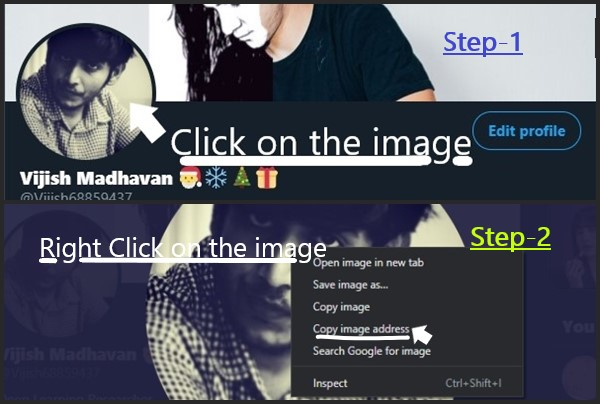

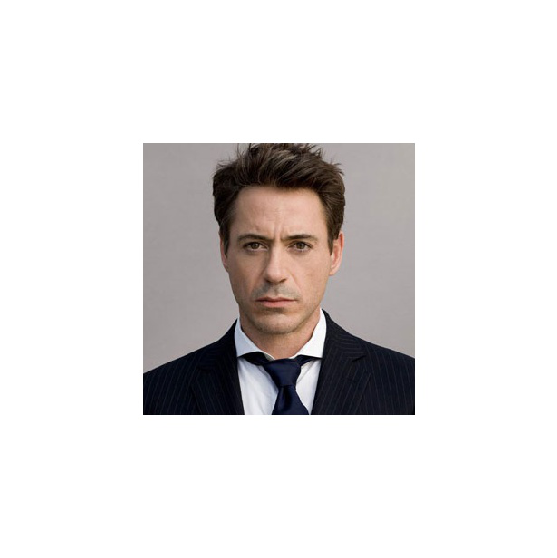

In [129]:
url = "https://mediamass.net/jdd/public/documents/celebrities/3946.jpg" #@param {type:"string"}

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")
im_new = add_margin(img, 150, 150, 150, 150, (255, 255, 255))
im_new.save("test.jpg", quality=95)
img = open_image("test.jpg")
show_image(img, figsize=(10, 10), interpolation='nearest');

p, img_hr, b = learn.predict(img)
x = np.minimum(np.maximum(image2np(img_hr.data*255), 0), 255).astype(np.uint8)
Image.fromarray(x).save("tes.jpg", quality=95)
img = open_image("tes.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


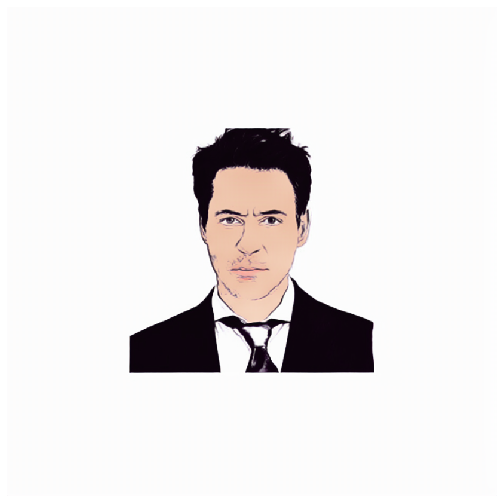

In [130]:
p, img_hr, b = learn_c.predict(img)
show_image(img_hr, figsize=(9, 9), interpolation='nearest');

# **Recommended image sources**

Link to high-quality portrait pics. Click on the image, let it expand and then copy image address.

https://www.freepik.com/search?dates=any&format=search&from_query=Portrait&page=1&query=Portrait&sort=popular&type=photo